# Setup

## Make some imports in order to add some libs

In [49]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier

## Load data

In [34]:
X_train = pd.read_csv('/Users/eduardoenriquez/Code/kaggle/titanic/data/train.csv')
X_test = pd.read_csv('/Users/eduardoenriquez/Code/kaggle/titanic/data/test.csv')

In [35]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Drop unuseful columns

### Ticket number

In [36]:
X_train.drop(['Ticket'], axis=1, inplace=True)
X_test.drop(['Ticket'], axis=1, inplace=True)
combine_df = [X_test, X_train]

###  Extract title name and normalize it

In [37]:
for dataset in combine_df:
    dataset['Title'] = X_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Lady', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Don', 'Mr')
    dataset['Title'] = dataset['Title'].replace('Dona', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Sir', 'Mr')
    
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr


In [38]:
pd.crosstab(X_train['Title'], X_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Dr,1,6
Jonkheer,0,1
Major,0,2
Master,0,40
Miss,186,0
Mr,0,519


## Changing Sex to Gender: Converting a categorical feature

In [39]:
for df in combine_df:
    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

##  Common embarked to null values

In [42]:
for df in combine_df:
    if len(df['Embarked'][ df['Embarked'].isnull() ]) > 0:
        most_common_value = df['Embarked'].dropna().mode().values
        df.Embarked.replace(np.NaN, most_common_value[0], inplace=True)

In [43]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr,1


## Here we can see another point of view. It depends on the cabin if someone survived? 

In [44]:
X_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


## And if we pay attention on the gender?

In [45]:
X_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


## Un problema que se presenta son las edades que se desconocen.
Una buena estrategia es llenar los valores faltantes a partir de los valores del grupo cercano
Por ejemplo se puede pensar que un indicador confiable de la edad de una persona es la edad promedio
de su clase social y su genero

In [58]:
X_train[np.isnan(X_train['Age'])==True].groupby(['Pclass','Sex'])['PassengerId'].count()

Pclass  Sex   
1       female     9
        male      21
2       female     2
        male       9
3       female    42
        male      94
Name: PassengerId, dtype: int64

Además el grupo social de 3ra clase es el que mas faltantes de edad tiene.

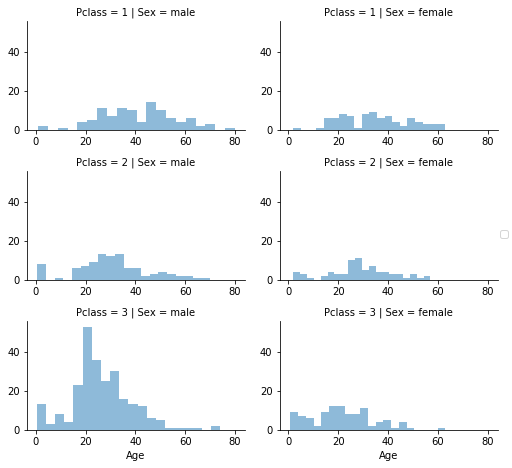

In [52]:
grid = sns.FacetGrid(X_train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [59]:
X_train[np.isnan(X_train['Age'])==False].groupby(['Pclass','Sex'])['Age'].median()

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [67]:
median_ages = np.zeros((2,3))
for gender in (0, 1):
    for pclass in (0, 1, 2):
        median_ages[gender, pclass] = X_train[(X_train['Gender'] == gender) & (X_train['Pclass'] == pclass + 1)]['Age'].dropna().median()

median_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

In [ ]:
df.drop(['Name', 'PassengerId', 'Fare', 'Ticket','Cabin', 'Sex'], axis=1, inplace=True)

In [32]:

ports = list(enumerate(np.unique(df['Embarked']))) 
ports_dict = { name : i for i, name in ports }
df.Embarked = df.Embarked.map(lambda x: ports_dict[x]).astype(int)

# Lo mismo con la edad, sino figura asignamos la edad promedio
median_age = df['Age'].dropna().median()
if len(df.Age[ df.Age.isnull() ]) > 0:
    df.Age[ df.Age.isnull() ] = median_age

/home/eduzen/.virtualenvs/kaggle-CiH6gmLr/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/eduzen/.virtualenvs/kaggle-CiH6gmLr/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [33]:
# Shape da el numero de filas y columnas
num_of_rows = df.shape[0]

# instancio un labelencoder 
label_encoder = LabelEncoder()
# instancio one hot enconder
one_encoder = OneHotEncoder()

# vamos a transformar la clase: 1°, 2° y 3° en tres columnas distitas con valores bool
new_columns_names = ['first_class', 'second_class', 'third_class']
# Usamos el label_encoder que va averiguar automaticamente cuales son todos los valores posibles
# en este caso es sencillo porque nosotros ya sabemos que son 3 valores posibles
passanger_classes = label_encoder.fit(df.Pclass) # esto da un array [1, 2, 3]  

# podria transformar los labels en numeros, en este caso no hace falta
integer_classes = passanger_classes.transform(passanger_classes.classes_).reshape(3, 1)

# Generados estos labels, transformo la columna en valores secuenciales que arrancan desde 0
# Si quiero volver a mis labels conocidos passanger_classes.inverse_transform(transformed)
transformed_passanger_classes = label_encoder.transform(df.Pclass).reshape(num_of_rows, 1) # esto da un array [0,1,2]

# con dichos valores construyo el one hot enconder que crea a partir de una row con tres valores posibles,
# un array con tres columnas.  
one_hot_encoder = one_encoder.fit(transformed_passanger_classes)
new_features = one_hot_encoder.transform(transformed_passanger_classes)
# Con este array multidimensional, voy a crear un dataframe con los nuevos nombres de columnas
new_df = pd.DataFrame(new_features.toarray(), columns=new_columns_names)

# finalmente concateno en un solo dataframe
pro_df = pd.concat([df, new_df], axis=1)

# y elimino la columna dantigua de Pclass
pro_df.drop('Pclass', axis=1, inplace=True)

In [34]:
survived = pro_df.Survived
pro_df.drop('Survived', axis=1, inplace=True)

In [35]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(pro_df, survived)

In [40]:
from io import StringIO
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=pro_df.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('titanic.png')

from IPython.core.display import Image 
Image(filename='titanic.png')

InvocationException: GraphViz's executables not found